In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# Football

In [2]:
df = pd.read_csv('football.csv')
df

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal
...,...,...,...,...,...,...,...,...,...,...,...,...
8920,m_57,p_115,open play,head,6.48,3.99,3,0,high,69,50,missed chance
8921,m_59,p_76,open play,right foot,21.45,-8.73,4,1,medium,15,53,blocked shot
8922,m_55,p_150,open play,left foot,11.97,3.24,3,0,medium,84,34,missed chance
8923,m_33,p_130,open play,right foot,6.48,-6.98,1,0,high,4,39,missed chance


In [3]:
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


In [4]:
df.describe()

,x,y,interveningOpponents,interveningTeammates,minute,second
count,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000
mean,14.564631,0.364408,2.531989,0.336471,48.541401,29.243810
std,7.841865,8.999063,1.386693,0.680175,26.397998,17.306565
min,0.000000,-33.920000,0.000000,0.000000,0.000000,0.000000
25%,8.480000,-5.740000,2.000000,0.000000,26.000000,14.000000
50%,12.470000,0.500000,2.000000,0.000000,49.000000,29.000000
75%,20.950000,6.730000,3.000000,0.000000,71.000000,44.000000
max,70.820000,33.920000,11.000000,7.000000,98.000000,59.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8925 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8925 non-null   object 
 1   playerId               8925 non-null   object 
 2   playType               8925 non-null   object 
 3   bodyPart               8925 non-null   object 
 4   x                      8925 non-null   float64
 5   y                      8925 non-null   float64
 6   interveningOpponents   8925 non-null   int64  
 7   interveningTeammates   8925 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8925 non-null   int64  
 10  second                 8925 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 836.8+ KB


handle missing values by filling them with the mode (most common value)

In [6]:
common_interference = df['interferenceOnShooter'].mode()[0]
common_outcome = df['outcome'].mode()[0]

df['interferenceOnShooter'].fillna(common_interference, inplace=True)
df['outcome'].fillna(common_outcome, inplace=True)

In [7]:
for column in df.columns:
    print(f"{column}:\n {df[column].unique()}")
    print("-----------------------------------------------------------------------")

matchId:
 ['m_91' 'm_17' 'm_111' 'm_142' 'm_117' 'm_147' 'm_88' 'm_66' 'm_132'
 'm_99' 'm_101' 'm_158' 'm_11' 'm_204' 'm_108' 'm_169' 'm_7' 'm_27' 'm_1'
 'm_68' 'm_203' 'm_124' 'm_186' 'm_140' 'm_3' 'm_235' 'm_209' 'm_231'
 'm_81' 'm_146' 'm_110' 'm_59' 'm_61' 'm_134' 'm_92' 'm_114' 'm_62' 'm_9'
 'm_144' 'm_96' 'm_184' 'm_177' 'm_154' 'm_143' 'm_148' 'm_196' 'm_51'
 'm_202' 'm_216' 'm_187' 'm_240' 'm_10' 'm_33' 'm_86' 'm_26' 'm_93'
 'm_149' 'm_131' 'm_139' 'm_65' 'm_25' 'm_167' 'm_224' 'm_226' 'm_238'
 'm_179' 'm_217' 'm_56' 'm_121' 'm_191' 'm_29' 'm_198' 'm_107' 'm_155'
 'm_173' 'm_74' 'm_208' 'm_237' 'm_67' 'm_137' 'm_145' 'm_80' 'm_200'
 'm_102' 'm_133' 'm_205' 'm_57' 'm_156' 'm_30' 'm_161' 'm_54' 'm_98'
 'm_125' 'm_39' 'm_4' 'm_44' 'm_141' 'm_206' 'm_195' 'm_22' 'm_20' 'm_69'
 'm_160' 'm_122' 'm_201' 'm_112' 'm_94' 'm_236' 'm_165' 'm_233' 'm_182'
 'm_164' 'm_213' 'm_6' 'm_63' 'm_55' 'm_89' 'm_222' 'm_178' 'm_48' 'm_46'
 'm_35' 'm_136' 'm_28' 'm_168' 'm_32' 'm_18' 'm_95' 'm_36' 'm_4

In [8]:
unique_values = ['goal', 'saved by keeper', 'missed chance', 'blocked shot', 'hit the post']
for value in unique_values:
    if value == 'goal': 
        df['outcome'].replace(value, 1, inplace=True)
    elif value == 'own goal': #there is no 'own goal' in dataset
        df['outcome'].replace(value, 1, inplace=True)
    else:
        df['outcome'].replace(value, 0, inplace=True)

In [9]:
df.rename(columns={"outcome": "scoredGoal"}, inplace=True)

In [10]:
x_train,x_test , y_train,y_test = train_test_split(df.drop('scoredGoal', axis=1), df.scoredGoal, random_state=110, stratify=df.scoredGoal)
model = AutoML()
model.fit(x_train, y_train, task='classification', time_budget=60, verbose=0)
y_pred = model.predict(x_test)
print(f'performance of model is {roc_auc_score(y_test, y_pred)}')

performance of model is 0.601427115188583


In [11]:
df.drop('matchId', inplace=True, axis=1)
df.drop('playerId', inplace=True, axis=1)
df

,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,scoredGoal
0,open play,right foot,13.47,-11.22,1,0,medium,70,9,1
1,open play,left foot,9.48,14.22,3,0,medium,55,4,0
2,free kick,left foot,29.43,-1.25,6,2,low,86,31,0
3,open play,right foot,26.93,1.00,4,1,medium,77,2,0
4,open play,right foot,10.72,5.24,2,0,medium,76,46,1
...,...,...,...,...,...,...,...,...,...,...
8920,open play,head,6.48,3.99,3,0,high,69,50,0
8921,open play,right foot,21.45,-8.73,4,1,medium,15,53,0
8922,open play,left foot,11.97,3.24,3,0,medium,84,34,0
8923,open play,right foot,6.48,-6.98,1,0,high,4,39,0


In [12]:
df['distance'] = np.sqrt((df['x'] ** 2) + (df['y'] ** 2))

goal_width = 7.32  # Width of the goal in meters
#df['theta'] = np.arctan2(goal_width * df['x'], (df['x']**2 + df['y']**2 - (goal_width / 2)**2))

df['angle'] = np.degrees(np.arctan2(goal_width * df['x'], (df['x']**2 + df['y']**2 - (goal_width / 2)**2)))#(df['theta'])

df.drop('x', inplace=True, axis=1)
df.drop('y', inplace=True, axis=1)
df

,playType,bodyPart,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,scoredGoal,distance,angle
0,open play,right foot,1,0,medium,70,9,1,17.530810,18.544088
1,open play,left foot,3,0,medium,55,4,0,17.090313,13.982592
2,free kick,left foot,6,2,low,86,31,0,29.456534,14.153255
3,open play,right foot,4,1,medium,77,2,0,26.948560,15.458384
4,open play,right foot,2,0,medium,76,46,1,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...
8920,open play,head,3,0,high,69,50,0,7.609895,46.818116
8921,open play,right foot,4,1,medium,15,53,0,23.158484,16.713121
8922,open play,left foot,3,0,medium,84,34,0,12.400746,31.970470
8923,open play,right foot,1,0,high,4,39,0,9.524222,31.529506


In [13]:
label_encoders = {}
for column in ['playType', 'bodyPart', 'interferenceOnShooter', 'scoredGoal']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

features = ['playType', 'bodyPart', 'interveningOpponents', 
            'interveningTeammates', 'interferenceOnShooter', 'minute', 'second', 'distance', 'angle']

mi_scores = mutual_info_classif(df[features], df['scoredGoal'], discrete_features=False)
temp = df.drop(['scoredGoal'], axis = 1)
index = [col for col in list(temp.columns)]
mi_results = pd.DataFrame({
    #'Feature': features,
    'Importance': mi_scores
}, index = index)

mi_results_sorted = mi_results.sort_values(by='Importance', ascending=False)
mi_results_sorted

,Importance
angle,0.056291
distance,0.054833
interveningOpponents,0.035103
playType,0.018599
interferenceOnShooter,0.006236
interveningTeammates,0.005198
bodyPart,0.003326
second,0.002585
minute,0.000778


In [14]:
model = AutoML(task='classification', time_budget=60, verbose=0)
columns_to_train = mi_results_sorted[mi_results_sorted.Importance >= mi_results_sorted.Importance.quantile(.5)].index
x = df[columns_to_train]
y = df.scoredGoal
model.fit(x,y)
x_train,x_test , y_train,y_test = train_test_split(x,y, random_state=110, test_size=.3, stratify=y)
y_pred = model.predict(x_test)
print(f'performance of model is {roc_auc_score(y_test, y_pred)}')

performance of model is 0.597504116974522


# Cars

In [15]:
df_car = pd.read_csv('cars.csv')
df_car

,Sales in Thousands,Year Resale Value,Price in Thousands,Engine Size,Horsepower,Wheelbase,Width,Length,Curb Weight,Fuel Capacity,Fuel Efficiency,Power Perf Factor,Vehicle Type Car,Vehicle Type Passenger
0,16.919,16.360,21.500,1.8,140,101.2,67.3,172.4,2.639,13.2,28,58.280150,0,1
1,39.384,19.875,28.400,3.2,225,108.1,70.3,192.9,3.517,17.2,25,91.370778,0,1
2,20.397,22.255,23.990,1.8,150,102.6,68.2,178.0,2.998,16.4,27,62.777639,0,1
3,18.780,23.555,33.950,2.8,200,108.7,76.1,192.0,3.561,18.5,22,84.565105,0,1
4,91.561,12.475,21.975,3.1,175,109.0,72.7,194.6,3.368,17.5,25,71.181451,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.761,11.425,14.900,2.0,115,98.9,68.3,163.3,2.767,14.5,26,46.943877,0,1
96,83.721,13.240,16.700,2.0,115,98.9,68.3,172.3,2.853,14.5,26,47.638237,0,1
97,51.102,16.725,21.200,1.8,150,106.4,68.5,184.1,3.043,16.4,27,61.701381,0,1
98,9.569,16.575,19.990,2.0,115,97.4,66.7,160.4,3.079,13.7,26,48.907372,0,1


In [16]:
df_car.head()

,Sales in Thousands,Year Resale Value,Price in Thousands,Engine Size,Horsepower,Wheelbase,Width,Length,Curb Weight,Fuel Capacity,Fuel Efficiency,Power Perf Factor,Vehicle Type Car,Vehicle Type Passenger
0,16.919,16.360,21.500,1.8,140,101.2,67.3,172.4,2.639,13.2,28,58.280150,0,1
1,39.384,19.875,28.400,3.2,225,108.1,70.3,192.9,3.517,17.2,25,91.370778,0,1
2,20.397,22.255,23.990,1.8,150,102.6,68.2,178.0,2.998,16.4,27,62.777639,0,1
3,18.780,23.555,33.950,2.8,200,108.7,76.1,192.0,3.561,18.5,22,84.565105,0,1
4,91.561,12.475,21.975,3.1,175,109.0,72.7,194.6,3.368,17.5,25,71.181451,0,1


In [17]:
df_car.describe()

,Sales in Thousands,Year Resale Value,Price in Thousands,Engine Size,Horsepower,Wheelbase,Width,Length,Curb Weight,Fuel Capacity,Fuel Efficiency,Power Perf Factor,Vehicle Type Car,Vehicle Type Passenger
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,66.591890,14.108400,21.303170,2.868000,166.590000,107.302000,70.988000,187.573000,3.262000,17.476000,24.570000,67.887260,0.280000,0.720000
std,78.510354,4.570593,6.756369,0.890339,42.585646,7.906831,3.625674,14.038215,0.582914,3.868106,4.492991,17.556987,0.451261,0.451261
min,0.110000,5.160000,9.235000,1.000000,55.000000,93.100000,62.600000,149.400000,1.895000,10.300000,15.000000,23.276272,0.000000,0.000000
25%,20.392750,10.593750,16.538750,2.000000,132.000000,102.550000,68.300000,177.900000,2.888750,15.075000,22.000000,53.527624,0.000000,0.000000
50%,37.646500,13.450000,20.470000,2.750000,165.500000,106.700000,70.300000,186.450000,3.272000,17.000000,25.000000,67.332736,0.000000,1.000000
75%,80.758500,16.875000,25.473750,3.500000,200.000000,109.825000,73.200000,195.150000,3.590250,19.000000,27.000000,81.212089,1.000000,1.000000
max,540.561000,26.975000,39.665000,5.200000,275.000000,138.700000,79.300000,224.500000,4.808000,32.000000,45.000000,113.765874,1.000000,1.000000


In [18]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sales in Thousands      100 non-null    float64
 1   Year Resale Value       100 non-null    float64
 2   Price in Thousands      100 non-null    float64
 3   Engine Size             100 non-null    float64
 4   Horsepower              100 non-null    int64  
 5   Wheelbase               100 non-null    float64
 6   Width                   100 non-null    float64
 7   Length                  100 non-null    float64
 8   Curb Weight             100 non-null    float64
 9   Fuel Capacity           100 non-null    float64
 10  Fuel Efficiency         100 non-null    int64  
 11  Power Perf Factor       100 non-null    float64
 12  Vehicle Type Car        100 non-null    int64  
 13  Vehicle Type Passenger  100 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 11.1

In [19]:
features = df_car.drop(columns=['Price in Thousands', 'Horsepower'])
target_price = df_car['Price in Thousands']
target_horsepower = df_car['Horsepower']

features_normalized = (features - features.mean()) / features.std()

X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
    features_normalized, target_price, test_size=0.2, random_state=42)

X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(
    features_normalized, target_horsepower, test_size=0.2, random_state=42)

X_train_price.shape, y_train_price.shape, X_train_hp.shape, y_train_hp.shape

((80, 12), (80,), (80, 12), (80,))

In [20]:
def initialize_weights(n_features):
    """ Initialize weights randomly close to zero """
    return np.zeros(n_features + 1) 

def predict(X, weights):
    """ Generate predictions using linear model """
    return np.dot(X, weights[1:]) + weights[0]

def cost_function(X, y, weights):
    """ Calculate mean squared error cost """
    predictions = predict(X, weights)
    errors = predictions - y
    return (1 / (2 * len(y))) * np.dot(errors.T, errors)

def gradient_descent(X, y, weights, learning_rate, iterations):
    """ Perform gradient descent to learn weights """
    cost_history = [0] * iterations
    m = len(y)
    
    for it in range(iterations):
        predictions = predict(X, weights)
        errors = predictions - y
        weights[1:] -= learning_rate * (1/m) * np.dot(X.T, errors)
        weights[0] -= learning_rate * (1/m) * np.sum(errors)
        cost_history[it] = cost_function(X, y, weights)
    
    return weights, cost_history

learning_rate = 0.01
iterations = 1000
n_features = X_train_price.shape[1]

weights_price = initialize_weights(n_features)

weights_price, cost_history_price = gradient_descent(X_train_price.values, y_train_price.values, weights_price, learning_rate, iterations)

print(weights_price) 
print("\n")
print(cost_history_price[-1])

[21.20773875 -0.16753795  3.01964537 -0.06443833 -0.49261106 -0.35468204
  0.04423425  2.29293681 -0.51851105  0.40650261  3.00503496 -0.0546471
  0.0546471 ]


1.6506184375858943


Text(0.5, 1.0, 'Predicted vs Actual for Price')

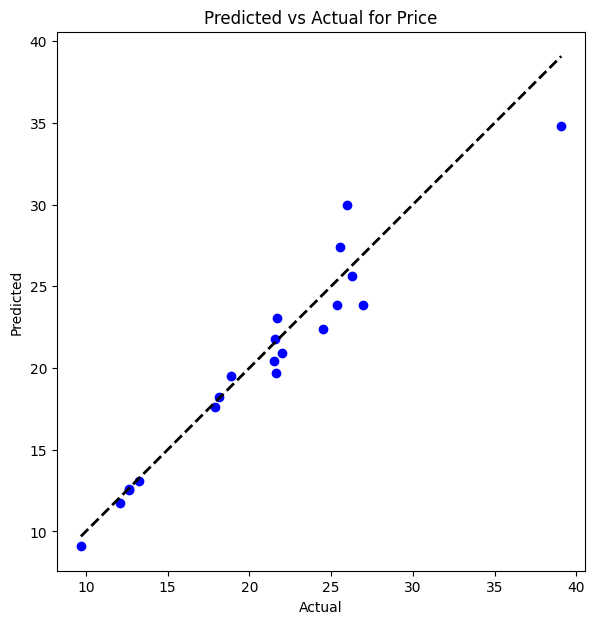

In [21]:
predictions_price = predict(X_test_price.values, weights_price)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_test_price, predictions_price, color='blue')
plt.plot([y_test_price.min(), y_test_price.max()], [y_test_price.min(), y_test_price.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual for Price')

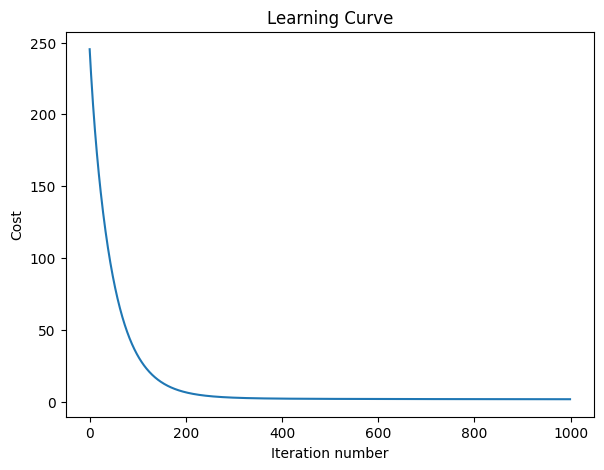

In [22]:
# Plotting learning curve
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.plot(cost_history_price)
plt.title('Learning Curve')
plt.xlabel('Iteration number')
plt.ylabel('Cost')
plt.show()

Text(0.5, 1.0, 'Predicted vs Actual for Horsepower')

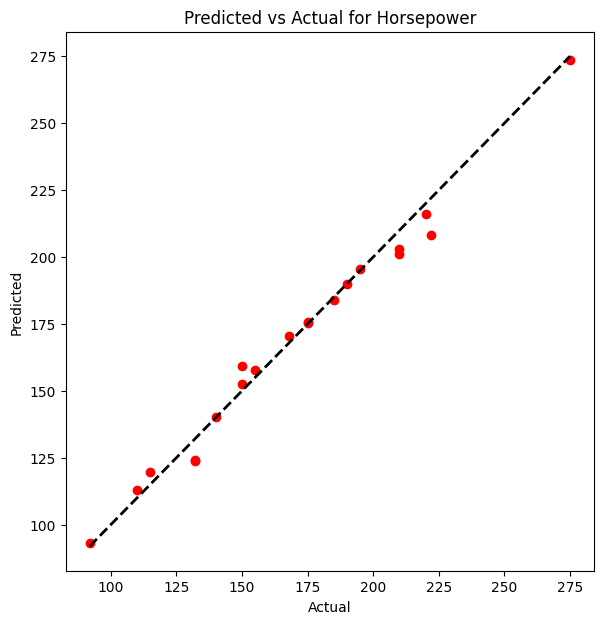

In [23]:
weights_hp = initialize_weights(n_features)

weights_hp, cost_history_hp = gradient_descent(X_train_hp.values, y_train_hp.values, weights_hp, learning_rate, iterations)

predictions_hp = predict(X_test_hp.values, weights_hp)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_test_hp, predictions_hp, color='red')
plt.plot([y_test_hp.min(), y_test_hp.max()], [y_test_hp.min(), y_test_hp.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual for Horsepower')


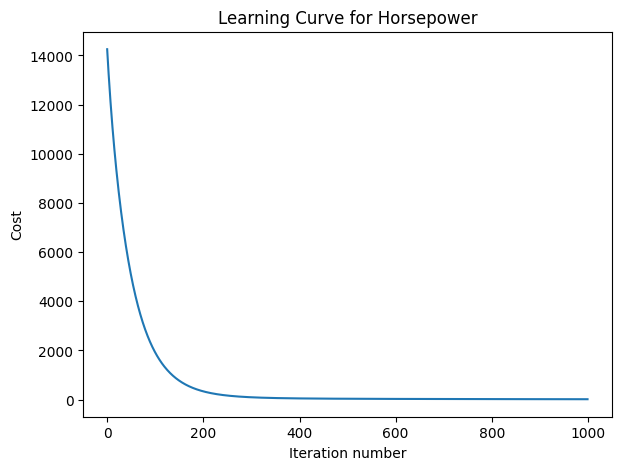

In [24]:
# Plotting learning curve for Horsepower
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.plot(cost_history_hp)
plt.title('Learning Curve for Horsepower')
plt.xlabel('Iteration number')
plt.ylabel('Cost')
plt.show()

# 3. Manual K-Fold Cross Validation Implementation

In [28]:
features = df_car.drop(columns=['Price in Thousands', 'Horsepower'])
target = df_car['Price in Thousands']  # can be changed to 'Horsepower'

# Normalize features
features_normalized = (features - features.mean()) / features.std()

# Convert to NumPy arrays for easier manipulation
X = features_normalized.values
y = target.values

def k_fold_split(X, y, K=5):
    """ Split the dataset into K folds """
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_sizes = np.full(K, len(X) // K, dtype=int)
    fold_sizes[:len(X) % K] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append((indices[start:stop], np.concatenate([indices[:start], indices[stop:]])))
        current = stop
    return folds

def train_and_evaluate(X_train, y_train, X_test, y_test, learning_rate, iterations):
    weights = initialize_weights(X_train.shape[1])
    weights, cost_history = gradient_descent(X_train, y_train, weights, learning_rate, iterations)
    predictions = predict(X_test, weights)
    mse = np.mean((predictions - y_test) ** 2)
    return mse, cost_history

# Perform K-Fold Cross Validation
K = 5
folds = k_fold_split(X, y, K)
mse_scores = []
all_cost_histories = []

for i, (test_idx, train_idx) in enumerate(folds):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    mse, cost_history = train_and_evaluate(X_train, y_train, X_test, y_test, 0.01, 1000)
    mse_scores.append(mse)
    all_cost_histories.append(cost_history)

    print(f"Fold {i+1} MSE: {mse}")

print(f"Average MSE across all folds: {np.mean(mse_scores)}")

Fold 1 MSE: 4.451437112430158
Fold 2 MSE: 2.9863063493242175
Fold 3 MSE: 4.253227061209721
Fold 4 MSE: 3.663098848564549
Fold 5 MSE: 6.899975493313855
Average MSE across all folds: 4.4508089729685


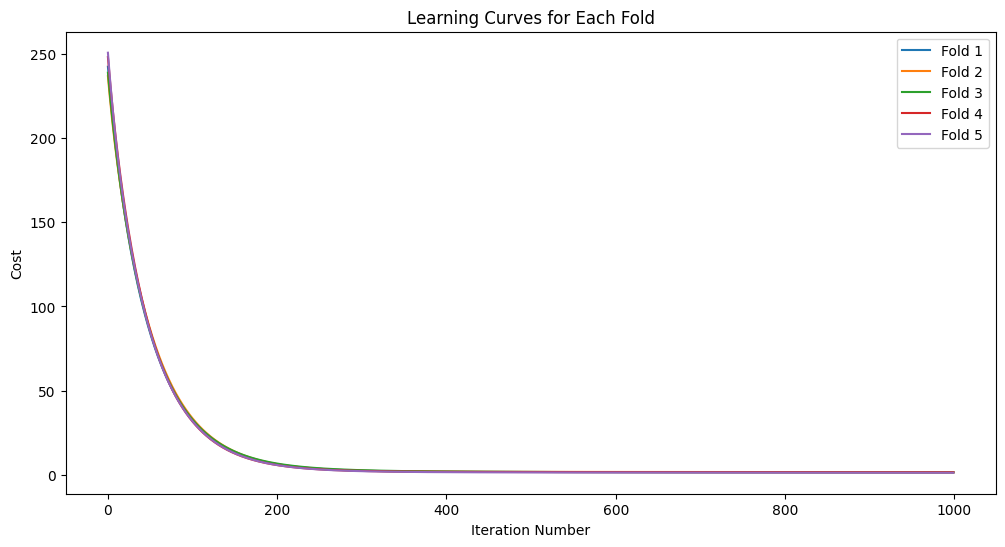

In [29]:
# Plotting learning curves for each fold
plt.figure(figsize=(12, 6))
for i in range(K):
    plt.plot(all_cost_histories[i], label=f'Fold {i+1}')

plt.title('Learning Curves for Each Fold')
plt.xlabel('Iteration Number')
plt.ylabel('Cost')
plt.legend()
plt.show()